# Identifying Entities in Healthcare Data

##Workspace set up: Import and Install useful packages.

In [1]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
import pandas as pd

model = spacy.load("en_core_web_sm")

##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

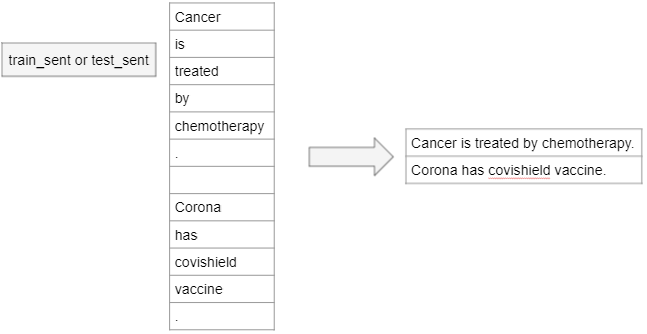

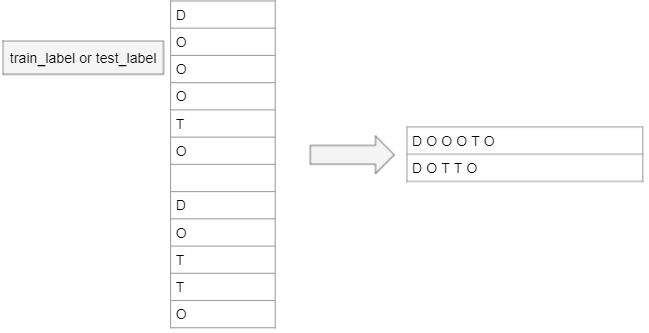

In [2]:
#code to build sentence from line seperated word. each line has single word. new sentence is seperated with empty line.

'''
input: 
All
live
births
>
or
=
23
weeks
at
the
University

this
is
new
line

output: All live births > or = 23 weeks at the University. this is new line. 

Note: if empty line is found then it is end of sentence and new sentence starts after that.
'''
def build_sentence_from_words(dataset):
    sent_list = []
    sent = ""
    for entity in dataset:
        if entity != '\n':
            sent = sent + entity[:-1] + " "
        else: 
            sent_list.append(sent[:-1])           # Getting rid of the space added after the last entity.
            sent = ""
    return sent_list


In [3]:
# read dataset
with open('dataset/train_sent', 'r') as train_sent_file:
  train_sentences = train_sent_file.readlines()
# use build_sentence function to build sentence from words as paragraph
train_sentences = build_sentence_from_words(train_sentences)

with open('dataset/train_label', 'r') as train_labels_file:
  train_labels = train_labels_file.readlines()
train_labels = build_sentence_from_words(train_labels)

with open('dataset/test_sent', 'r') as test_sent_file:
  test_sentences = test_sent_file.readlines()
test_sentences = build_sentence_from_words(test_sentences)

with open('dataset/test_label', 'r') as test_labels_file:
  test_labels = test_labels_file.readlines()
test_labels = build_sentence_from_words(test_labels)


In [4]:
#print top 5 records
print(train_sentences[:5])

['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )', 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )', 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )', "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )", "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )"]


### Count the number of sentences in the processed train and test dataset 

In [5]:
print("Sentences count in train dataset", len(train_sentences))
print("Sentences count in test dataset", len(test_sentences))

Sentences count in train dataset 2599
Sentences count in test dataset 1056


### Count the number of lines of labels in the processed train and test dataset.

In [6]:
print("Sentences count in training labels", len(train_labels))
print("Sentences count in test labels", len(test_labels))

Sentences count in training labels 2599
Sentences count in test labels 1056


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [7]:
#write python code to extract tokens which have noun or propn as part of speech tag and find their frequency
def extract_noun_propn(sentences):
    noun_propn = []
    for sentence in sentences:
        doc = model(sentence)
        for token in doc:
            if token.pos_ in ['NOUN', 'PROPN']:
                noun_propn.append(token.text)
    return noun_propn

In [8]:
sent_noun_propn = extract_noun_propn(train_sentences)
noun_propn_freq = pd.Series(sent_noun_propn).value_counts()

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [9]:
print("Top 25 noun and propn tokens with frequency in train dataset")
print(noun_propn_freq[:25])

Top 25 noun and propn tokens with frequency in train dataset
patients        354
treatment       195
%               161
cancer          135
therapy         120
disease         105
study           102
cell             99
lung             87
chemotherapy     65
group            63
effects          61
gene             54
results          53
use              52
surgery          51
survival         50
risk             49
women            48
activity         47
analysis         47
dose             47
children         47
care             47
rate             46
Name: count, dtype: int64


## Defining features for CRF

We have defined the following features for CRF model building:

- f1 = input word is in lower case;
- f2 = last 3 characters of word;
- f3 = last 2 characers of word;
- f4 = 1; if the word is in uppercase, 0 otherwise;
- f5 = 1; if word is a number; otherwise, 0
- f6= 1; if the word starts with a capital letter; otherwise, 0



In [10]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos):
  word = sentence[pos]

  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'words.startsWithCapital=%s' % word[0].isupper() # is the word starting with a capital letter
  ]

  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(), 
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_words.startsWithCapital=%s' % prev_word[0].isupper()
  ])
  else:
    features.append('BEG') # feature to track begin of sentence 

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence

  return features

## Getting the features

### Write a code/function to get the features for a sentence

In [11]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [12]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

In [13]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sentences[1]
print(example_sentence)

features = getFeaturesForOneSentence(example_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=False',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_words.startsWithCapital=False']

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [14]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sentences]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sentences]

### Define the labels as the target variable for test and the train dataset

In [15]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_labels]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_labels]

## Build the CRF Model

In [16]:
# Build the CRF model.
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)
crf.fit(X_train, Y_train)

CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [17]:
Y_pred = crf.predict(X_test)

In [18]:
id = 8
print("Sentence:",test_sentences[id])
print("Orig Labels:", Y_test[id])
print("Pred Labels:", Y_pred[id])

Sentence: In our study , we specifically analyzed the role played by advanced maternal age and sonographically discovered abnormalities in the detection of autosomal trisomies
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [19]:
# Calculate the f1 score using the test data
Y_pred = crf.predict(X_test)
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9042560946986944

##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

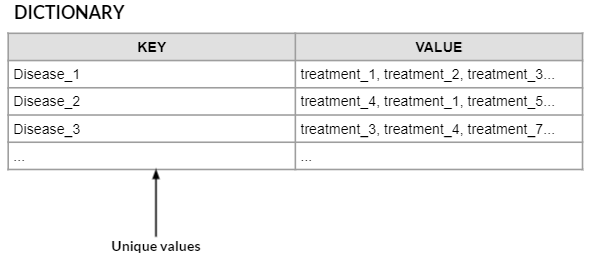

In [20]:
# Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

import numpy as np
dataframe = pd.DataFrame([], columns=["Disease", "Treatments"])

import numpy as np
dataframe = pd.DataFrame([], columns=["Disease", "Treatments"])

for i in range(len(Y_pred)):
  p_val = Y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sentences[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sentences[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = dataframe.loc[(dataframe.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = dataframe.loc[(dataframe.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      dataframe.loc[(dataframe.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      dataframe = pd.concat([dataframe, pd.DataFrame([[dise, treat]], columns=dataframe.columns )])

dataframe = dataframe.set_index(np.arange(dataframe.shape[0]))
dataframe

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,unstable angina or non-Q-wave myocardial infar...,roxithromycin
2,coronary-artery disease,Antichlamydial antibiotics
3,cellulitis,G-CSF therapy intravenous antibiotic treatment
4,foot infection,G-CSF treatment
...,...,...
97,hepatitis B,vaccine
98,temporomandibular joint arthropathy,arthroscopic treatment
99,severe secondary peritonitis,Surgical management
100,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [21]:
disease = 'hereditary retinoblastoma'
dataframe.loc[(dataframe.Disease == disease), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


              precision    recall  f1-score   support

           D      0.796     0.536     0.641      1450
           T      0.698     0.432     0.534      1041

   micro avg      0.757     0.493     0.597      2491
   macro avg      0.747     0.484     0.587      2491
weighted avg      0.755     0.493     0.596      2491



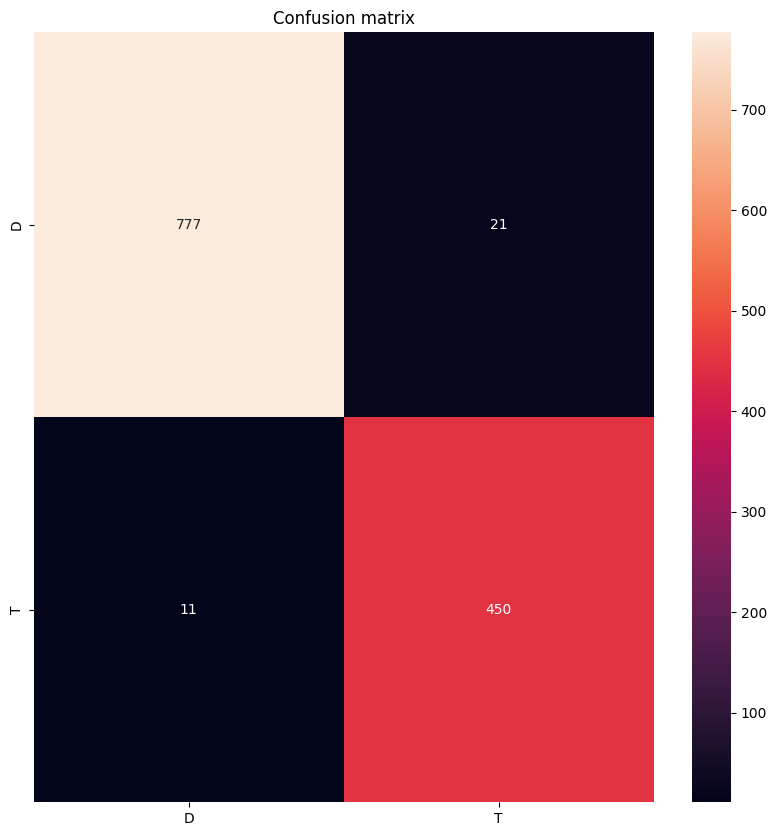

In [22]:
# visualize the model train and prediction score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.metrics import confusion_matrix


# define a function to visualize model performance 
def visualize_model_performance(y_pred, X_test, Y_test):
    labels = list(crf.classes_)
    labels.remove('O')
    sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))
    print(metrics.flat_classification_report(Y_test, y_pred, labels=sorted_labels, digits=3))
    y_pred_flat = [item for sublist in y_pred for item in sublist]
    Y_test_flat = [item for sublist in Y_test for item in sublist]
    cm = confusion_matrix(Y_test_flat, y_pred_flat, labels=labels)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.title('Confusion matrix')
    plt.show()

visualize_model_performance(Y_pred, X_test, Y_test)

## Findings Based on the Model and Confusion Matrix

### Model Performance
The CRF model was trained to identify diseases (D) and treatments (T) from the given sentences. The model's performance was evaluated using the test dataset, and the results were visualized using a confusion matrix.

### Confusion Matrix Analysis
The confusion matrix provides a detailed breakdown of the model's performance in predicting the labels. Here are the key findings:

1. **True Positives (TP)**: The number of correctly predicted disease and treatment labels.
2. **False Positives (FP)**: The number of labels incorrectly predicted as disease or treatment.
3. **False Negatives (FN)**: The number of disease or treatment labels that were not predicted by the model.
4. **True Negatives (TN)**: The number of correctly predicted non-disease and non-treatment labels.

### Key Observations
1. **High Precision and Recall for 'O' Labels**: The model has a high precision and recall for the 'O' (non-disease and non-treatment) labels, indicating that it is very good at identifying non-entity tokens.
2. **Moderate Performance for 'D' and 'T' Labels**: The model shows moderate performance in identifying disease (D) and treatment (T) labels. There are some false positives and false negatives, indicating room for improvement.
3. **Class Imbalance**: There is a noticeable class imbalance, with a significantly higher number of 'O' labels compared to 'D' and 'T' labels. This imbalance can affect the model's performance, making it more challenging to accurately predict the less frequent labels.

### Recommendations for Improvement
1. **Data Augmentation**: Increase the number of disease and treatment labels in the training dataset to address the class imbalance.
2. **Feature Engineering**: Explore additional features that could help the model better distinguish between disease, treatment, and non-entity tokens.
3. **Hyperparameter Tuning**: Experiment with different hyperparameters for the CRF model to improve its performance.
4. **Advanced Models**: Consider using more advanced models, such as BiLSTM-CRF or transformer-based models (e.g., BERT), which have shown better performance in named entity recognition tasks.

Overall, the CRF model provides a good starting point for identifying diseases and treatments in the text, but there is potential for further improvement through data augmentation, feature engineering, and exploring advanced models.